In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Acquisition

## Saving Relevant Articles

This loads the articles we wish to investigate.

In [122]:
articles_df = pd.read_csv('/Users/zach/Jupyter/DATA 512/thank_the_academy.AUG.2023.csv')

This saves the article names we're interested in as a list.

In [123]:
articles = articles_df['name'].tolist()

## Acquiring the Mobile Data

### Accessing the Mobile-Web Data

Here we set the parameters for accessing the API and define a function for doing so

In [124]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

In [125]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<zprice12@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

In [128]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

This acquires the relevant data from the API for each article and combines their info into a single dataframe.

In [129]:
web_df = pd.DataFrame(columns=['project', 'article', 'granularity', 'timestamp', 'access', 'agent', 'views'])
for art in ARTICLE_TITLES:
    views = request_pageviews_per_article(art)
    temp_df = pd.DataFrame.from_dict(views['items'])
    web_df = pd.concat([web_df, temp_df], axis=0)

### Accessing the Mobile-App Data

Here we set the parameters for accessing the API and define a function for doing so

In [130]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<zprice12@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

In [131]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

This acquires the relevant data from the API for each article and combines their info into a single dataframe.

In [132]:
app_df = pd.DataFrame(columns=['project', 'article', 'granularity', 'timestamp', 'access', 'agent', 'views'])
for art in ARTICLE_TITLES:
    views = request_pageviews_per_article(art)
    temp_df = pd.DataFrame.from_dict(views['items'])
    app_df = pd.concat([app_df, temp_df], axis=0)

### Combining the Mobile-Web and Mobile-App Data

Here we combine the mobile-web and mobile-app data into one dataframe.

In [133]:
mobile_df = pd.concat([web_df, app_df], axis=0)

This combines the counts for the web and app mobile data.

In [134]:
mobile_df = mobile_df.groupby(['article','timestamp'], as_index=False)['views'].sum()

## Acquiring the Desktop Data

Here we set the parameters for accessing the API and define a function for doing so

In [135]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<zprice12@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

In [136]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

This acquires the relevant data from the API for each article and combines their info into a single dataframe.

In [137]:
desk_df = pd.DataFrame(columns=['project', 'article', 'granularity', 'timestamp', 'access', 'agent', 'views'])
for art in ARTICLE_TITLES:
    views = request_pageviews_per_article(art)
    temp_df = pd.DataFrame.from_dict(views['items'])
    desk_df = pd.concat([desk_df, temp_df], axis=0)

Here we drop columns so we are left with the article, timestamp, and view count.

In [138]:
desk_df = desk_df.drop(columns=['project', 'granularity', 'access', 'agent'])

## Creating the Cumulative Data

This combines the mobile and desktop data into one dataframe.

In [139]:
cumul_df = pd.concat([desk_df, mobile_df], axis=0)
cumul_df = cumul_df.groupby(['article','timestamp'], as_index=False)['views'].sum()

## Final Data Cleaning and Saving

This resets the indices for each dataframe to avoid duplicates when outputting as a json file.

In [140]:
mobile_df = mobile_df.reset_index(drop=True)
desk_df = desk_df.reset_index(drop=True)
cumul_df = cumul_df.reset_index(drop=True)

Here we save the mobile data as a json file.

In [141]:
mobile_df.to_json('/Users/zach/Jupyter/DATA 512/academy_monthly_mobile_201507-202309.json', orient='index')

Here we save the desktop data as a json file.

In [142]:
desk_df.to_json('/Users/zach/Jupyter/DATA 512/academy_monthly_desktop_201507-202309.json', orient='index')

Here we save the cumulative data as a json file.

In [143]:
cumul_df.to_json('/Users/zach/Jupyter/DATA 512/academy_monthly_cumulative_201507-202309.json', orient='index')

# Analysis

## Maximum Average and Minimum Average

This converts the timestamp field to a datetime object for use in plotting.

In [167]:
mobile_df['timestamp']= pd.to_datetime(mobile_df['timestamp'], format='%Y%m%d%H')
desk_df['timestamp']= pd.to_datetime(desk_df['timestamp'], format='%Y%m%d%H')

This gets the average request count for each article and finds the high and low for mobile.

In [307]:
mobile_avg = mobile_df.groupby(['article'], as_index=False)['views'].mean()
mobile_low = mobile_avg.sort_values(by=['views']).iloc[0,0]
mobile_high = mobile_avg.sort_values(by=['views'], ascending=False).iloc[0,0]

This gets the average request count for each article and finds the high and low for desktop.

In [308]:
desk_avg = desk_df.groupby(['article'], as_index=False)['views'].mean()
desk_low = desk_avg.sort_values(by=['views']).iloc[0,0]
desk_high = desk_avg.sort_values(by=['views'], ascending=False).iloc[0,0]

This filters the data to contain only the desired high and low average articles.

In [309]:
mobile_vis = mobile_df[mobile_df['article'].isin([mobile_low, mobile_high])]
desk_vis = desk_df[desk_df['article'].isin([desk_low, desk_high])]

Here we plot the high and low for mobile and desktop article requests.

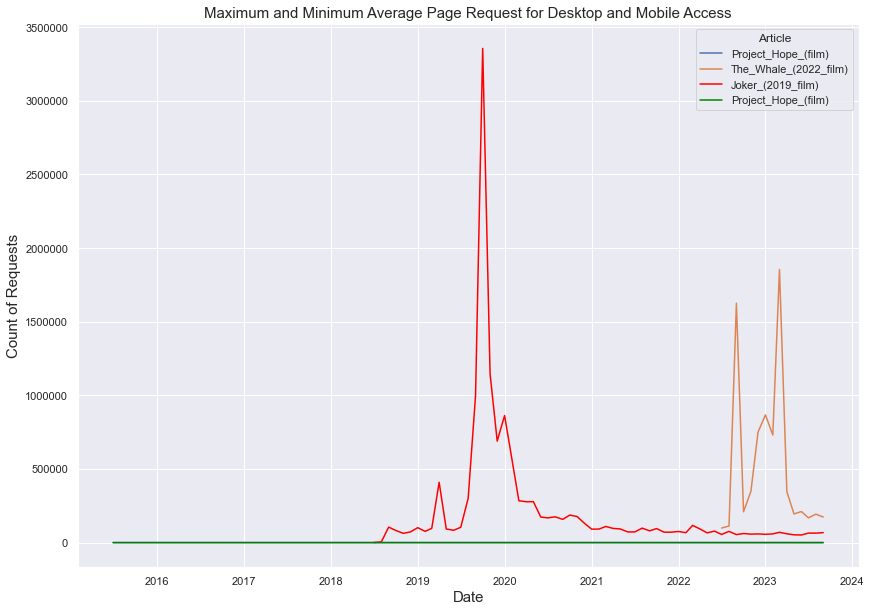

In [310]:
sns.set(rc={'figure.figsize':(14,10)})
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
sns.lineplot(x = 'timestamp', y = 'views', hue='article', data = mobile_vis)
sns.lineplot(x = 'timestamp', y = 'views', hue='article', data = desk_vis, palette=['red', 'green'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count of Requests', fontsize=15)
plt.title('Maximum and Minimum Average Page Request for Desktop and Mobile Access', fontsize=15)
plt.legend(title='Article')

## Top 10 Peak Page Views

This saves the top ten peak viewed mobile articles as a list.

In [311]:
mobile_max = mobile_df.groupby(['article'], as_index=False)['views'].max().sort_values(by=['views'], ascending=False).iloc[:10,0].to_list()

This saves the top ten peak viewed desktop articles as a list.

In [312]:
desk_max = desk_df.groupby(['article'], as_index=False)['views'].max().sort_values(by=['views'], ascending=False).iloc[:10,0].to_list()

This filters the data to contain only the desired high and low average articles.

In [313]:
mobile_vis = mobile_df[mobile_df['article'].isin(mobile_max)]
desk_vis = desk_df[desk_df['article'].isin(desk_max)]

Here we plot the top ten peak requested articles for mobile and desktop.

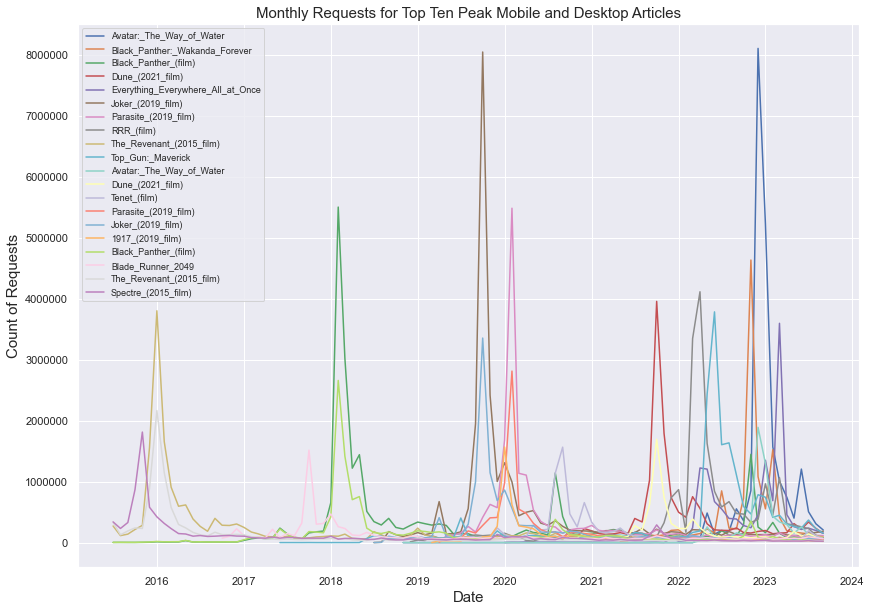

In [314]:
sns.set(rc={'figure.figsize':(14,10)})
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
sns.lineplot(x = 'timestamp', y = 'views', hue='article', data = mobile_vis)
sns.lineplot(x = 'timestamp', y = 'views', hue='article', data = desk_vis, palette='Set3')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count of Requests', fontsize=15)
plt.title('Monthly Requests for Top Ten Peak Mobile and Desktop Articles', fontsize=15)
plt.legend(title='', fontsize=9)

## Fewest Months of Data

This saves the 10 articles with the least mobile data as a list.

In [315]:
mobile_min = mobile_df.groupby(['article'], as_index=False)['views'].count().sort_values(by=['views']).iloc[:10,0].to_list()

This saves the 10 articles with the least desktop data as a list.

In [316]:
desk_min = desk_df.groupby(['article'], as_index=False)['views'].count().sort_values(by=['views']).iloc[:10,0].to_list()

This filters the data to contain only the desired high and low average articles.

In [317]:
mobile_vis = mobile_df[mobile_df['article'].isin(mobile_min)]
desk_vis = desk_df[desk_df['article'].isin(desk_min)]

This plots a time series of the 10 articles for mobile and desktop with the least data.

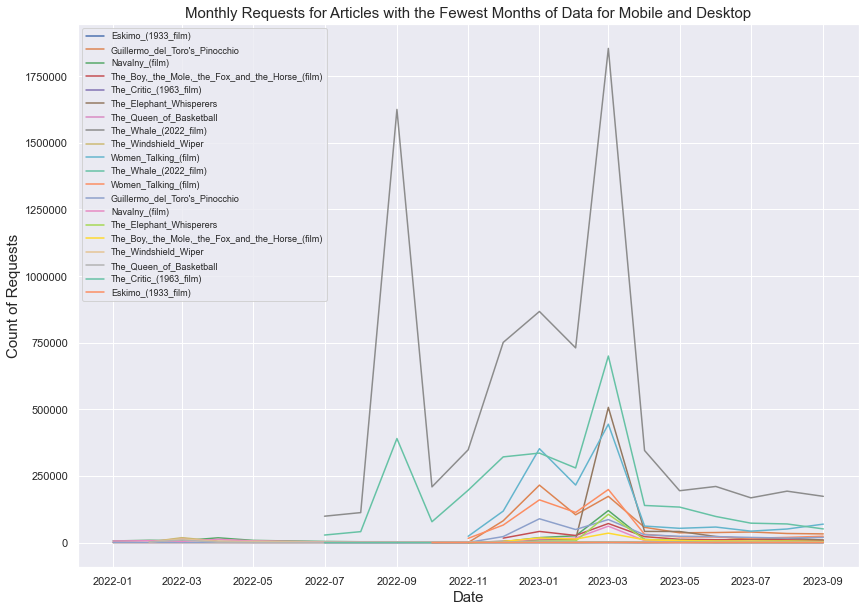

In [318]:
sns.set(rc={'figure.figsize':(14,10)})
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
sns.lineplot(x = 'timestamp', y = 'views', hue='article', data = mobile_vis)
sns.lineplot(x = 'timestamp', y = 'views', hue='article', data = desk_vis, palette='Set2')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count of Requests', fontsize=15)
plt.title('Monthly Requests for Articles with the Fewest Months of Data for Mobile and Desktop', fontsize=15)
plt.legend(title='', fontsize=9)